Pictures 1 and 2 are being stitched together


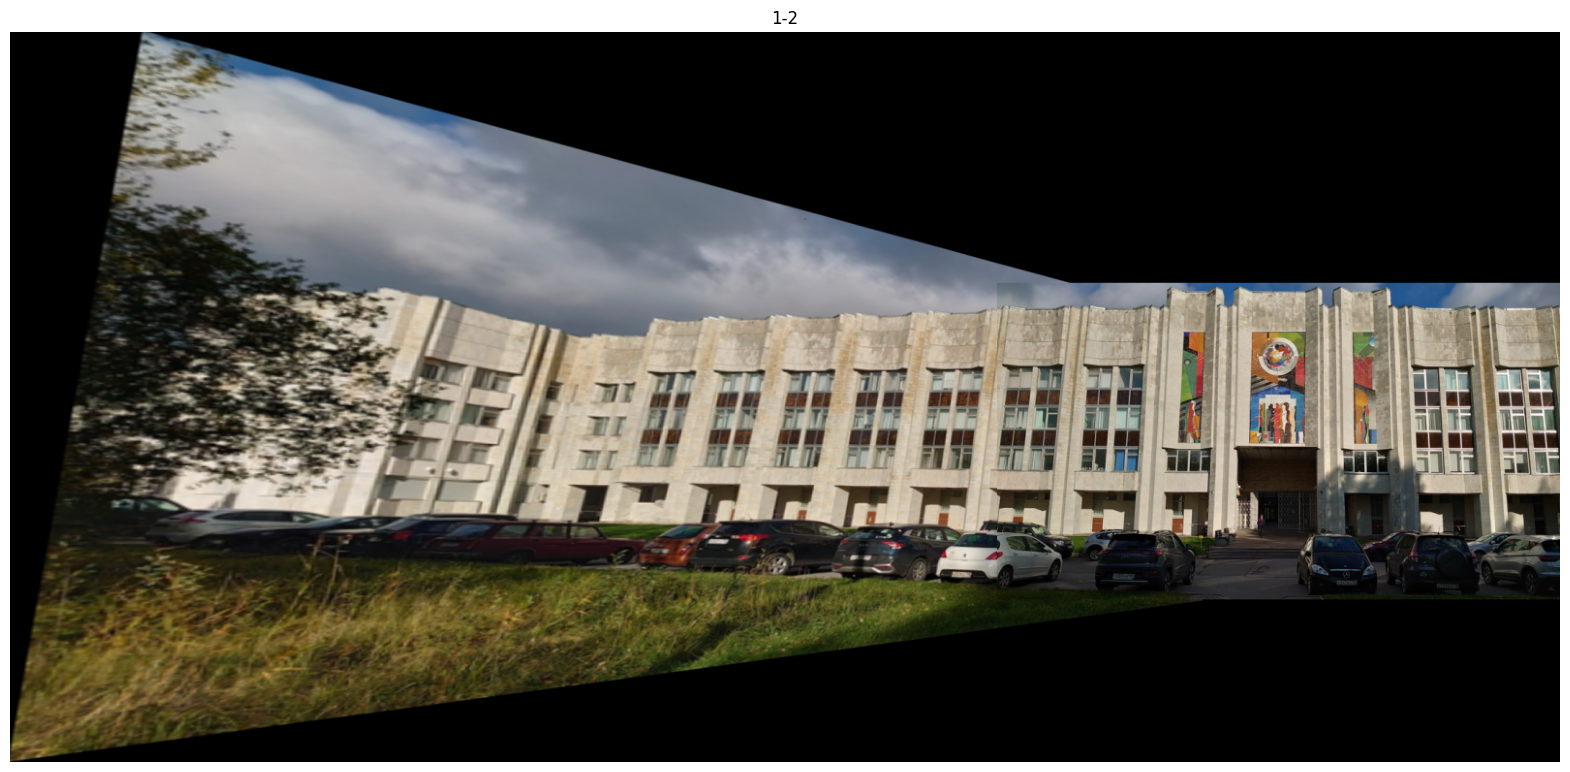

Pictures 3 and 4 are being stitched together


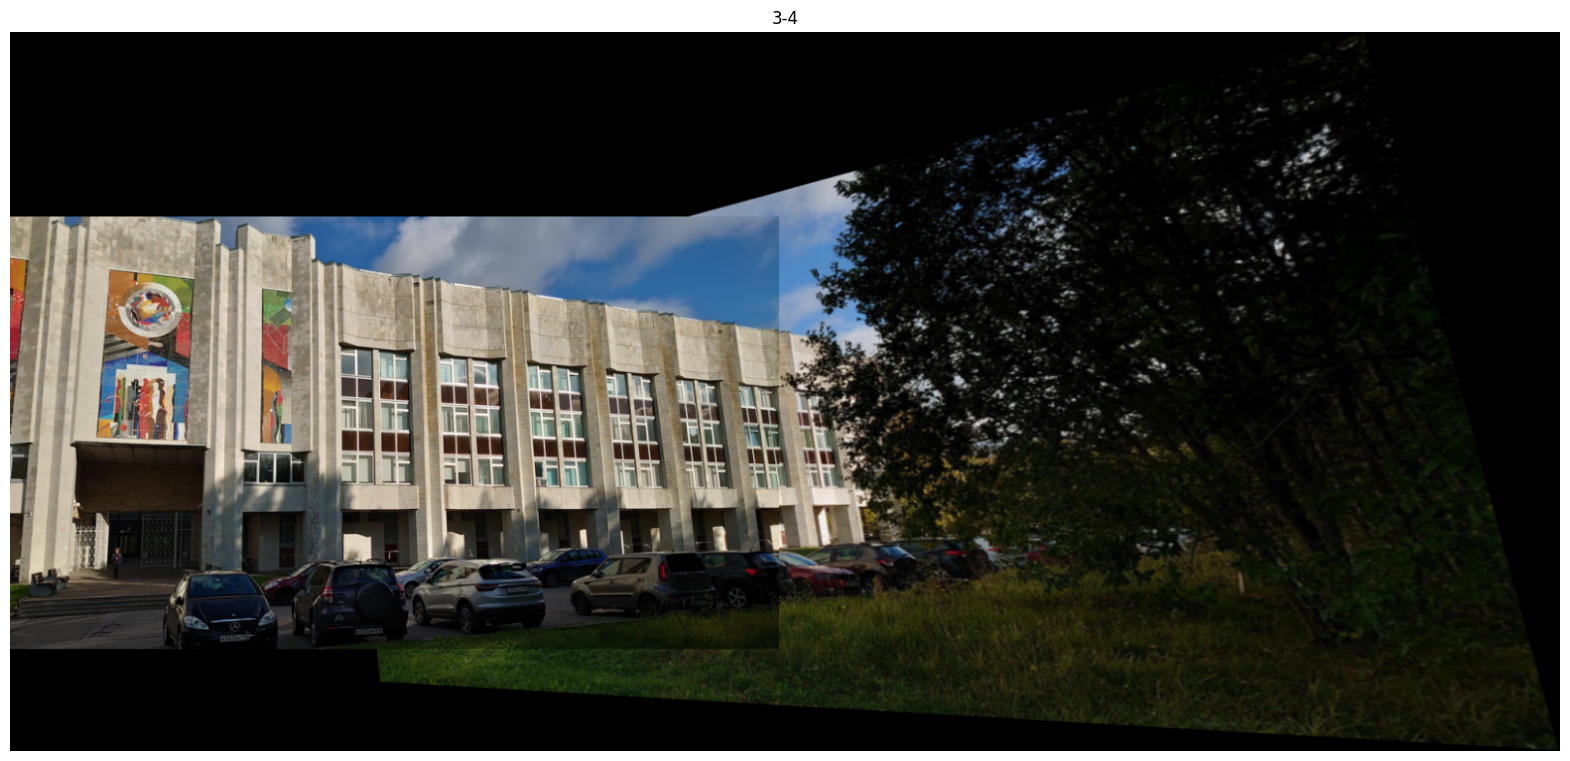

Results of 1-2 being spliced with 3-4


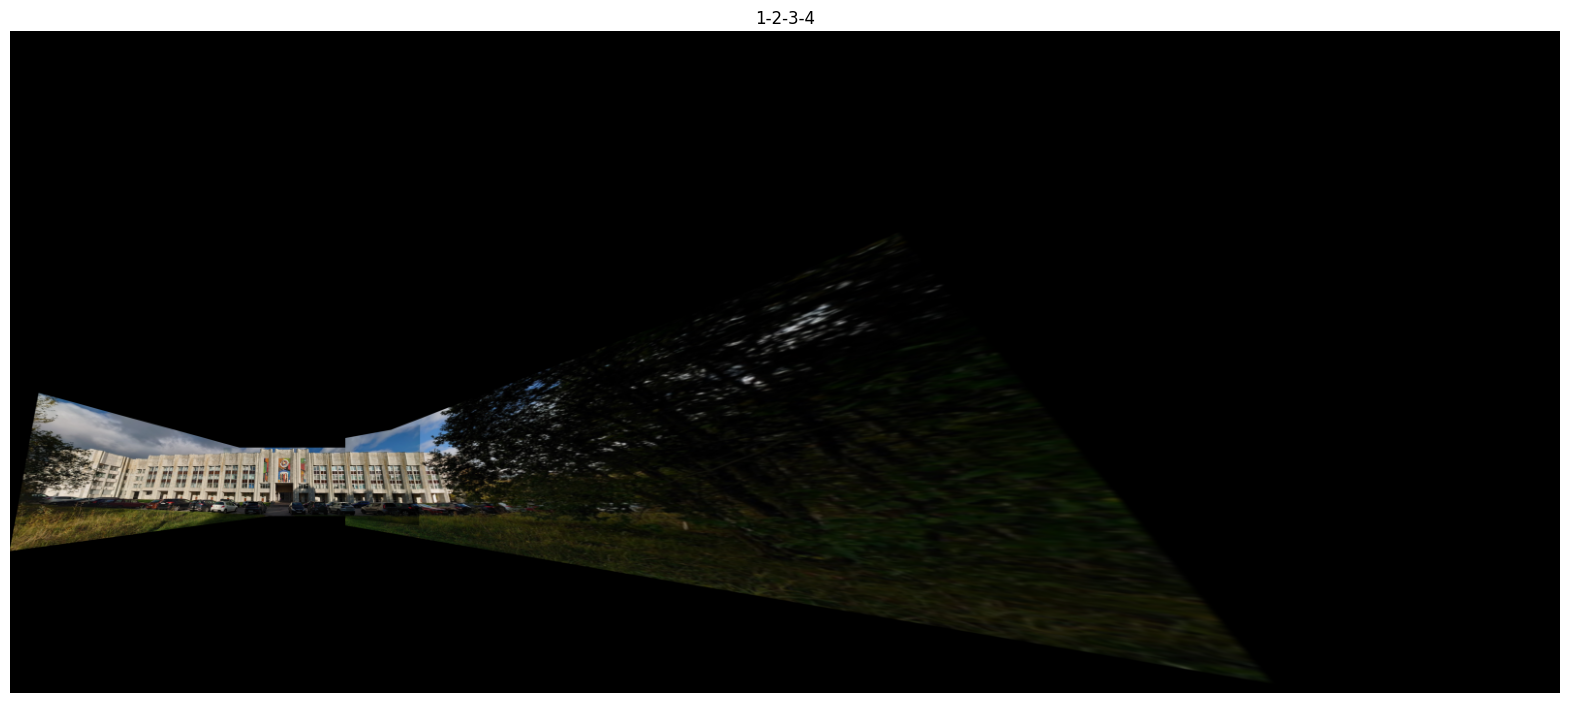

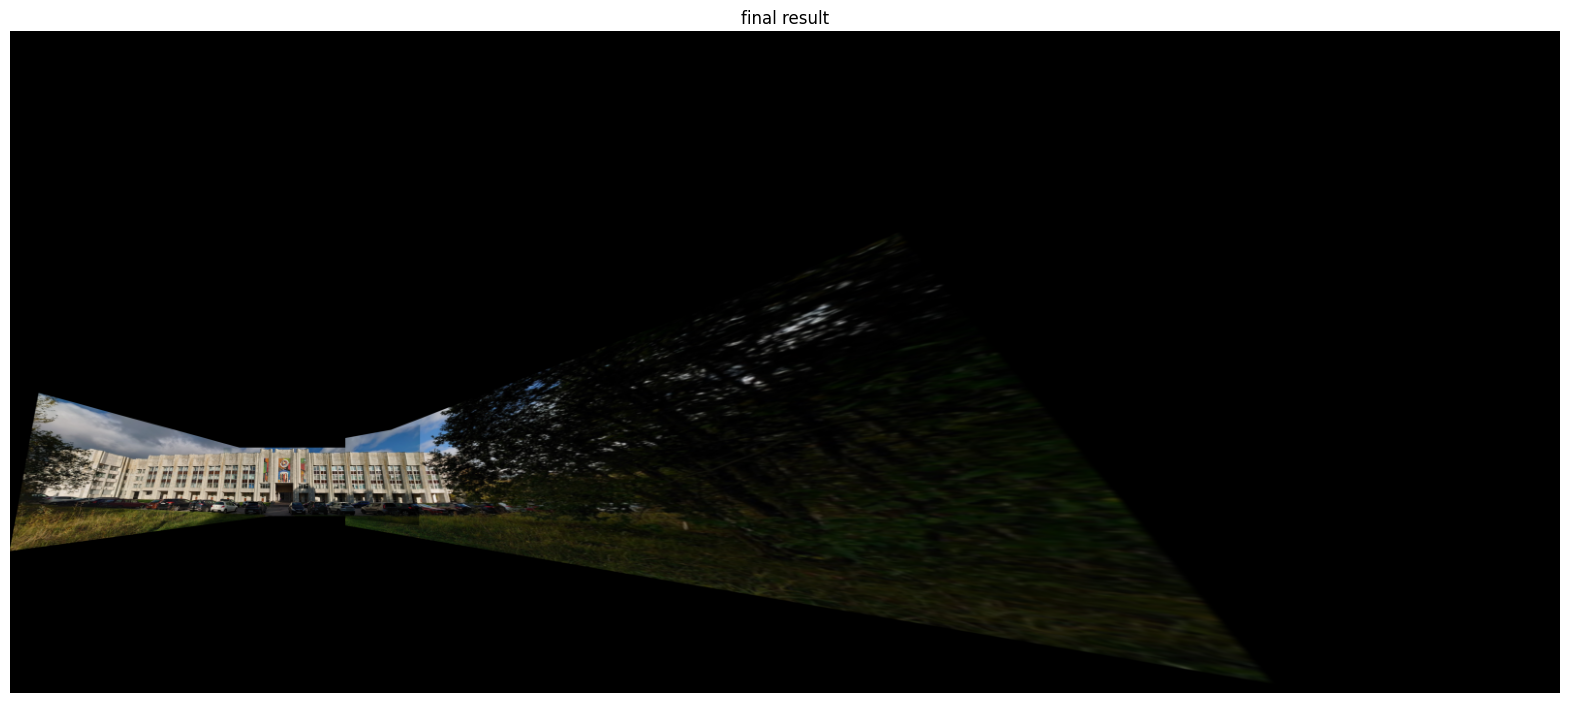

In [48]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import re

def load_images_from_folder(folder):
    files = os.listdir(folder)
    numbers = [int(re.findall(r'\d+(?=\.[^.]+$)', f)[0]) for f in files]
    sorted_files = sorted(zip(files, numbers), key=lambda x: x[1])
    
    images = []
    for filename, _ in sorted_files:
        img = cv.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

def resize_with_aspect_ratio(image, max_size):
    height, width = image.shape[:2]
    if height > width:
        if height > max_size:
            ratio = max_size / height
            new_height = max_size
            new_width = int(width * ratio)
    else:
        if width > max_size:
            ratio = max_size / width
            new_width = max_size
            new_height = int(height * ratio)
    
    if height > max_size or width > max_size:
        image = cv.resize(image, (new_width, new_height), interpolation=cv.INTER_AREA)
    return image

def warpImages(img1, img2, H):
    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]

    list_of_points_1 = np.float32([[0, 0], [0, rows1], [cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    temp_points = np.float32([[0, 0], [0, rows2], [cols2, rows2], [cols2, 0]]).reshape(-1, 1, 2)

    list_of_points_2 = cv.perspectiveTransform(temp_points, H)
    list_of_points = np.concatenate((list_of_points_1, list_of_points_2), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

    translation_dist = [-x_min, -y_min]
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

    output_img = cv.warpPerspective(img1, H_translation.dot(H), (x_max-x_min, y_max-y_min))
    output_img[translation_dist[1]:rows2+translation_dist[1], translation_dist[0]:cols2+translation_dist[0]] = img2

    return output_img

def stitch_pair(img_top, img_bottom):
    kp_top, des_top = orb.detectAndCompute(img_top, None)
    kp_bottom, des_bottom = orb.detectAndCompute(img_bottom, None)
    
    matches = bf.knnMatch(des_bottom, des_top, k=2)
    
    good = []
    for m, n in matches:
        if m.distance < 0.6 * n.distance:
            good.append(m)
            
    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([kp_bottom[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_top[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        
        M, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
        result = warpImages(img_bottom, img_top, M)
        
        return result
    else:
        print("Not finding enough matches")
        return None

def process_panorama(folder, max_size=800):
    images = load_images_from_folder(folder)
    images = [resize_with_aspect_ratio(img, max_size) for img in images]
    
    print("Pictures 1 and 2 are being stitched together")
    result12 = stitch_pair(images[1], images[0])
    if result12 is not None:
        result12 = resize_with_aspect_ratio(result12, max_size * 2)
        plt.figure(figsize=(20, 10))
        plt.imshow(cv.cvtColor(result12, cv.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('1-2')
        plt.show()
    
    print("Pictures 3 and 4 are being stitched together")
    result34 = stitch_pair(images[2], images[3])
    if result34 is not None:
        result34 = resize_with_aspect_ratio(result34, max_size * 2)
        plt.figure(figsize=(20, 10))
        plt.imshow(cv.cvtColor(result34, cv.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('3-4')
        plt.show()
    
    
    print("Results of 1-2 being spliced with 3-4")
    if result12 is not None and result34 is not None:
        final_result = stitch_pair(result12, result34)
        if final_result is not None:
            final_result = resize_with_aspect_ratio(final_result, max_size * 2)
            plt.figure(figsize=(20, 10))
            plt.imshow(cv.cvtColor(final_result, cv.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title('1-2-3-4')
            plt.show()
            return final_result
    
    return None

folder = "building2"
MIN_MATCH_COUNT = 10
orb = cv.ORB_create(nfeatures=2000)
bf = cv.BFMatcher_create(cv.NORM_HAMMING)

final_result = process_panorama(folder, max_size=800)

if final_result is not None:
    plt.figure(figsize=(20, 10))
    plt.imshow(cv.cvtColor(final_result, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('final result')
    plt.show()